In [1]:
import os
import numpy as np
import torch
import open3d as o3d
import matplotlib.pyplot as plt
import pyrealsense2 as rs
from sam2.build_sam import build_sam2_video_predictor

from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images

from superprimitive_fusion.demo import (
    get_frames,
    detect_yellow,
    segment_video,
    predict_geometry,
    delete_contents,
    crop_centre,
    get_sorted_frames,
    get_superprimitive,
)

from superprimitive_fusion.scanner import (
    triangulate_rgbd_grid_grouped,
)

from superprimitive_fusion.utils import (
    plot_images,
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = torch.device("cuda")
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [3]:
TMP_VID_DIR = './tmp_vid/'
sam2_checkpoint = "../../models/SAM2/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
vggt_crop = (518, 392)

In [4]:
vggt_model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)

In [5]:
sam2_predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [14]:
delete_contents(TMP_VID_DIR)
frames, keyframe_idx = get_frames()
for i,frame in enumerate(frames):
    plt.imsave(TMP_VID_DIR+f'{i}.jpg', crop_centre(frame, *vggt_crop))

In [31]:
frames = get_sorted_frames(TMP_VID_DIR)
keyframe_idx = [4, 12, 20, 26]

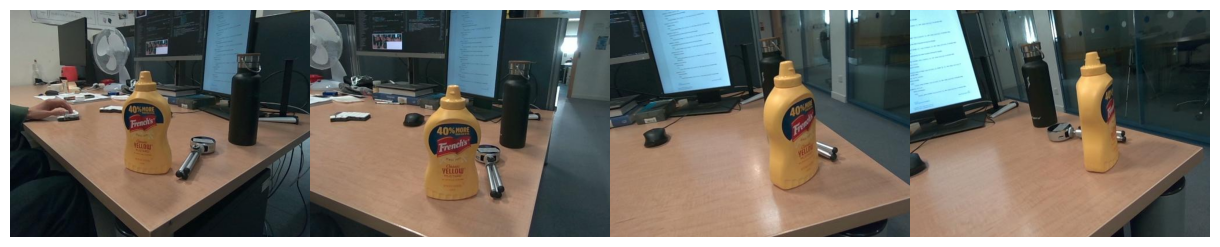

In [32]:
_=plot_images([frames[i] for i in keyframe_idx], max_cols=4)

In [ ]:
import os, torch, numpy as np
from vggt.utils.load_fn import load_and_preprocess_images
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

def _to_SHW1_depth(x_np: np.ndarray) -> np.ndarray:
    """Coerce depth to (S, H, W, 1). Handles (B,S,*,*,1), (S,*,*,1), (S,1,*,*), (S,*,*)."""
    x = np.asarray(x_np)
    # Drop batch if present
    if x.ndim == 5 and x.shape[0] == 1:
        x = x[0]                           # (S, H, W, 1) or (S, 1, H, W)
    # Channel-last already?
    if x.ndim == 4 and x.shape[-1] == 1:
        return x                           # (S, H, W, 1)
    # Channel-first single channel?
    if x.ndim == 4 and x.shape[1] == 1:
        return np.transpose(x, (0, 2, 3, 1))  # (S, H, W, 1)
    # No explicit channel -> add it
    if x.ndim == 3:
        return x[..., None]                # (S, H, W, 1)
    raise ValueError(f"Unexpected depth shape {x_np.shape}")

def _to_SHW_conf(x_np: np.ndarray) -> np.ndarray:
    """Coerce conf to (S, H, W). Handles (B,S,H,W), (S,1,H,W), (S,H,W,1)."""
    x = np.asarray(x_np)
    if x.ndim == 4 and x.shape[0] == 1:    # drop batch
        x = x[0]
    if x.ndim == 4 and x.shape[1] == 1:
        x = x.squeeze(1)
    if x.ndim == 4 and x.shape[-1] == 1:
        x = x.squeeze(-1)
    if x.ndim != 3:
        raise ValueError(f"Unexpected conf shape {x_np.shape}")
    return x

def _drop_batch(x_np: np.ndarray) -> np.ndarray:
    """Drop leading batch dim if it is 1."""
    x = np.asarray(x_np)
    return x[0] if x.ndim >= 2 and x.shape[0] == 1 else x

def predict_geometry(model, jpg_video_path: str,
                     image_names: None | list[str],
                     kf_idx: None | list[int],
                     device=torch.device("cuda")):
    # Gather images
    if image_names is None:
        image_names = sorted([f for f in os.listdir(jpg_video_path) if f.lower().endswith(".jpg")])
    kf_image_names = image_names if kf_idx is None else [image_names[i] for i in kf_idx]
    paths = [os.path.join(jpg_video_path, n) for n in kf_image_names]

    images = load_and_preprocess_images(paths).to(device)

    with torch.no_grad():
        pred = model(images)

    # Cameras from pose encoding (returns (B,S,3,4) and (B,S,3,3) in your case)
    extri_t, intri_t = pose_encoding_to_extri_intri(pred["pose_enc"], images.shape[-2:])

    # ---- Convert to numpy + normalise shapes ----
    depth_np = _to_SHW1_depth(pred["depth"].detach().cpu().numpy())     # -> (S,H,W,1)
    conf_np  = _to_SHW_conf(pred["depth_conf"].detach().cpu().numpy())  # -> (S,H,W)
    extri_np = _drop_batch(extri_t.detach().cpu().numpy()).astype(np.float32)  # -> (S,3,4)
    intri_np = _drop_batch(intri_t.detach().cpu().numpy()).astype(np.float32)  # -> (S,3,3)

    # Quick sanity checks (fail fast with clear messages)
    assert depth_np.ndim == 4 and depth_np.shape[-1] == 1, depth_np.shape
    assert conf_np.ndim == 3, conf_np.shape
    assert extri_np.ndim == 3 and extri_np.shape[1:] == (3, 4), extri_np.shape
    assert intri_np.ndim == 3 and intri_np.shape[1:] == (3, 3), intri_np.shape
    assert depth_np.shape[:3] == conf_np.shape[:3] == (extri_np.shape[0],) + depth_np.shape[1:3], (
        depth_np.shape, conf_np.shape, extri_np.shape)

    # Depth → world points (numpy in, numpy out): (S,H,W,3)
    wp = unproject_depth_map_to_point_map(depth_np, extri_np, intri_np)

    return wp, conf_np, depth_np

In [62]:
points, conf, depth = predict_geometry(vggt_model, TMP_VID_DIR, None, keyframe_idx, device)

In [34]:
must_mask, must_centr = detect_yellow(frames[0])

In [35]:
masks = segment_video(sam2_predictor, TMP_VID_DIR, must_centr, 0)

frame loading (JPEG):   0%|          | 0/30 [00:00<?, ?it/s]

frame loading (JPEG): 100%|██████████| 30/30 [00:00<00:00, 88.04it/s]
/home/christopher/Documents/Code/segment-anything-2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/home/christopher/Documents/Code/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 30/30 [00:02<00:00, 14.39it/s]


(<Figure size 600x227.027 with 2 Axes>,
 array([<Axes: >, <Axes: >], dtype=object))

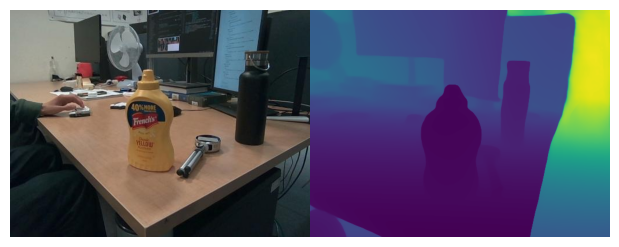

In [66]:
rgb = np.array(frames)
plot_images([rgb[0], depth[0]])

In [67]:
m = conf > 1.8
rgb = np.array(frames)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[m].reshape(-1,3))
pcd.colors = o3d.utility.Vector3dVector(rgb[keyframe_idx][m].reshape(-1,3)/255)
o3d.visualization.draw_geometries([pcd])

In [22]:
c = 0.5
meshes = []
for i,kf_id in enumerate(keyframe_idx):
    mesh = get_superprimitive(conf[i], masks[kf_id], depth[i], points[i], frames[kf_id], conf_thresh=c, k=10)
    mesh.compute_vertex_normals()
    meshes.append(mesh)

o3d.visualization.draw_geometries(meshes)